In [1]:
import osmnx as ox
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import rasterio.merge

from rasterio.mask import mask
import geopandas as gpd
import json
from pathlib import Path


# DEM Mosaic from GIS-Steiermark Dataset?

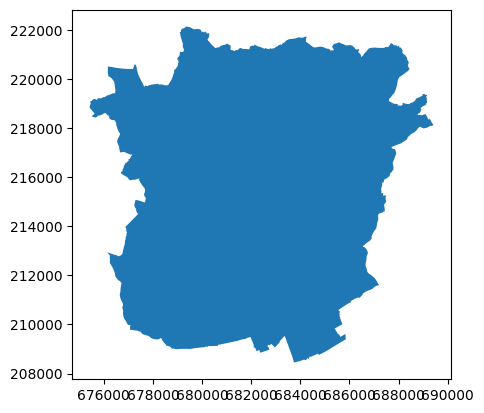

In [2]:


PLACE = "Graz, Austria"

graz = ox.geocode_to_gdf(PLACE)
graz_31259 = graz.to_crs(31259) 
graz_31259.plot()

minx, miny, maxx, maxy = graz_31259.total_bounds
minx, miny, maxx, maxy = map(float, (minx, miny, maxx, maxy))

In [5]:

# Directory containing all DEM tiles
tile_dir = Path("../data/MidtermPro/Backup_Cache/DEM_BMN_M34")

# List all .tif files
tif_files = sorted(tile_dir.glob("*.tif"))
print("Number of tiles:", len(tif_files))

# Open all tile datasets
srcs = [rasterio.open(fp) for fp in tif_files]

# Create mosaic from tiles
mosaic, mosaic_transform = rasterio.merge.merge(srcs)

# Copy metadata from first tile and update for mosaic
meta = srcs[0].meta.copy()
meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": mosaic_transform
})


Number of tiles: 0


IndexError: list index out of range

In [4]:
# Output path for full mosaic raster
mosaic_path = Path("../data/MidtermPro/Data/dem_mosaic.tif")
mosaic_path.parent.mkdir(parents=True, exist_ok=True)

# Write mosaic raster to disk
with rasterio.open(mosaic_path, "w", **meta) as dst:
    dst.write(mosaic)

print("Mosaic saved to:", mosaic_path)

# hab das nicht weiter hinbekommen, die höhenwerte verschwinden beim mosaikieren


NameError: name 'meta' is not defined

# DEM Clip to Graz Boundary

In [ ]:


# Paths
dem_path = Path("../data/MidtermPro/Data/dem_mosaic31256.tif")
graz_path = Path("../data/MidtermPro/Data/Graz31256.geojson")

# Load Graz polygon
graz = gpd.read_file(graz_path)


# Extract geometry in GeoJSON format
graz_geom = [json.loads(graz.to_json())["features"][0]["geometry"]]

# Clip raster
with rasterio.open(dem_path) as src:
    dem_clip, dem_transform = mask(
        src,
        graz_geom,
        crop=True,
        nodata=src.nodata
    )
    clip_meta = src.meta.copy()
    clip_meta.update({
        "height": dem_clip.shape[1],
        "width": dem_clip.shape[2],
        "transform": dem_transform,
        "nodata": src.nodata
    })

# Save clipped DEM
clip_path = Path("../data/MidtermPro/Data/dem_graz31256.tif")

with rasterio.open(clip_path, "w", **clip_meta) as dst:
    dst.write(dem_clip)

print("DEM Graz saved:", clip_path)

# Quick min/max check
import numpy as np
masked = np.ma.masked_equal(dem_clip, clip_meta["nodata"])
print("DEM Graz min:", masked.min(), "max:", masked.max())

DataSourceError: ../data/MidtermPro/Data/Graz31259.geojson: No such file or directory

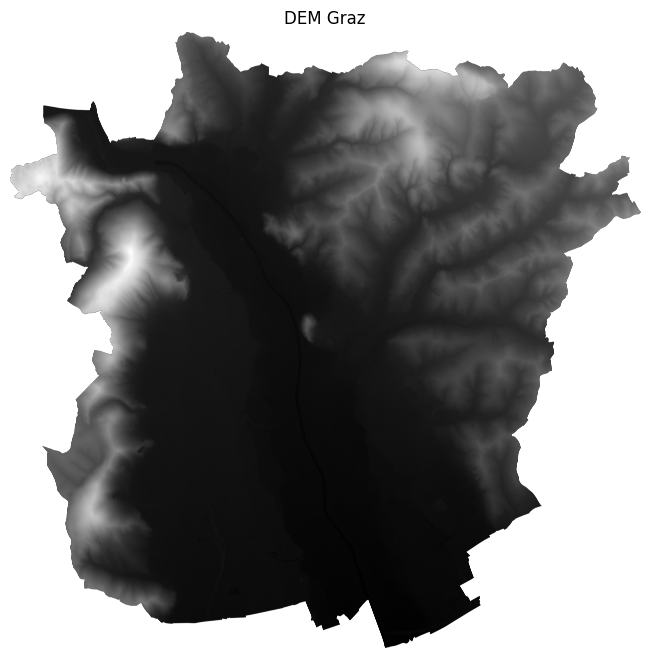

In [ ]:

nodata = clip_meta["nodata"]

# Remove band dimension and mask NoData
dem = dem_clip[0]
masked = np.ma.masked_equal(dem, nodata)

plt.figure(figsize=(10, 8))
plt.imshow(masked, cmap="gray")  

#plt.title("DEM Graz")
plt.axis("off")
plt.show()

# Urban Atlas Clip to Graz Boundary

In [ ]:
import geopandas as gpd
from pathlib import Path

# Paths
ua_path   = Path("../data/MidtermPro/Data/UrbanAtlas31256.gpkg")
graz_path = Path("../data/MidtermPro/Data/Graz31256.geojson")

# Load layers
urban_atlas = gpd.read_file(ua_path)
graz = gpd.read_file(graz_path)



# Fix: explicitly set correct CRS for Urban Atlas
urban_atlas = urban_atlas.set_crs("EPSG:31256", allow_override=True)

print("Urban Atlas CRS:", urban_atlas.crs)

# Clip Urban Atlas to Graz boundary
ua_graz = gpd.clip(urban_atlas, graz)

print("Original UA features:", len(urban_atlas))
print("Clipped UA features:", len(ua_graz))

# Save clipped Urban Atlas
ua_clip_path = Path("../data/MidtermPro/Data/UrbanAtlasGraz31256.gpkg")
ua_graz.to_file(ua_clip_path, driver="GPKG")

print("Clipped Urban Atlas saved to:", ua_clip_path)


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Load clipped Urban Atlas (EPSG:31256)
ua_path = "../data/MidtermPro/Data/UrbanAtlasGraz31256.gpkg"
ua_graz = gpd.read_file(ua_path)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ua_graz.plot(
    ax=ax,
    color="lightgray",    # uniform gray fill
    edgecolor="dimgray",  # darker boundaries
    linewidth=0.3
)

#ax.set_title("UrbanAtlasGraz", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


# Timon Schritte

In [ ]:
# define the place name
place_name:str = "Graz, Austria"
# get the boundary polygon of Graz
graz_gdf = ox.geocode_to_gdf(place_name)
graz_gdf.to_file("graz_boundary.geojson", driver="GeoJSON")
# change the crs to an Austrian metric CRS EPSG: 31256
graz_gdf = graz_gdf.to_crs(epsg=31256)






'\nThe author\'s of the paper obtained the road and drainage network from the Ministry of Agriculture\nand the Addis Ababa city land administration. We use the logical equivalent from OSM.\nPaper speaks of "drainage" also in respect to recreation. For that, we will choose rivers and streams.\ntags: waterway=river, waterway=stream, waterway=canal for drainage network\n\nFor the road network, accessibility and pollution is relevant, so will choose the drivable road network.\nnetwork_type=\'drive\' for drivable road network (excluding footways, cycleways, etc.)\n\n\n\n'

In [ ]:
"""
The author's of the paper obtained the road and drainage network from the Ministry of Agriculture
and the Addis Ababa city land administration. We use the logical equivalent from OSM.
Paper speaks of "drainage" also in respect to recreation. For that, we will choose rivers and streams.
tags: waterway=river, waterway=stream, waterway=canal for drainage network

For the road network, accessibility and pollution is relevant, so will choose the drivable road network.
network_type='drive' for drivable road network (excluding footways, cycleways, etc.)
"""

# get the road network within Graz
road_graph = ox.graph_from_place(place_name, network_type='drive')
road_gdf = ox.graph_to_gdfs(road_graph, nodes=False, edges=True)
road_gdf = road_gdf.to_crs(epsg=31256)
road_gdf.to_file("graz_road_network.geojson", driver="GeoJSON")

# get the drainage network within Graz
#https://wiki.openstreetmap.org/wiki/Key:waterway
drainage_tags = {'waterway': ['river', 'stream', 'canal']}
drainage_gdf = ox.features_from_place(place_name, tags=drainage_tags)
drainage_gdf = drainage_gdf.to_crs(epsg=31256)
drainage_gdf.to_file("graz_drainage_network.geojson", driver="GeoJSON")

# we only want lines, no polygons or points
drainage_gdf = drainage_gdf[drainage_gdf.geometry.type.isin(['LineString', 'MultiLineString'])]
drainage_gdf = drainage_gdf[['geometry', 'waterway', 'name']] # keep names
drainage_gdf.to_file("graz_drainage_network.geojson", driver="GeoJSON")

# print summary
print(f"Graz boundary: {graz_gdf.shape[0]} features")
print(f"Graz road network: {road_gdf.shape[0]} features")
print(f"Graz drainage network: {drainage_gdf.shape[0]} features")

Graz boundary: 1 features
Graz road network: 11255 features
Graz drainage network: 997 features


In [ ]:
"""
Make raster base layer for Graz with 10m resolution
"""
# define raster parameters
raster_res = 10  # 10 meters
minx, miny, maxx, maxy = graz_gdf.total_bounds

  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ----- ---------------------------------- 3.4/25.4 MB 16.7 MB/s eta 0:00:02
   --------- ------------------------------ 6.0/25.4 MB 14.2 MB/s eta 0:00:02
   -------------- ------------------------- 9.2/25.4 MB 15.0 MB/s eta 0:00:02
   ------------------- -------------------- 12.3/25.4 MB 14.8 MB/s eta 0:00:01
   ------------------------ --------------- 15.5/25.4 MB 14.7 MB/s eta 0:00:01
   ------------------------------ --------- 19.4/25.4 MB 15.1 MB/s eta 0:00:01
   ----------------------------------- ---- 22.8/25.4 MB 15.5 MB/s eta 0:00:01
   ---------------------------------------  25.4/25.4 MB 15.6 MB/s eta 0:00:01
   ---------------------------------------- 25.4/25.4 MB 14.9 MB/s eta 0:00:00
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
   ------------------------------


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
